In [41]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [1]:
# utilities
import os
import sys
from tqdm import tqdm
import random

In [2]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

In [12]:
from pycaret.classification import *

RuntimeError: 'inline is not a recognised GUI loop or backend name

In [3]:
from scipy import signal
from scipy.io import wavfile
from scipy.signal import butter,filtfilt
from scipy.signal import hilbert
from scipy.signal import resample
from scipy.signal import decimate
from scipy.signal import spectrogram
from scipy.signal.windows import get_window

In [4]:
import seaborn as sns

In [5]:
ROOT = 'coughvid-dataset/'
class_names = ['healthy','COVID-19','symptomatic']
audio_length = 22050

# load coughvid meta
data_raw = pd.read_csv('metadata_compiled.csv')
data_raw.head(3)

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,2020-11-25T18:58:50.488301+00:00,0.0155,7.326171,48.9,2.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,male,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,female,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data_raw.status.value_counts()

status
healthy        12479
symptomatic     2590
COVID-19        1155
Name: count, dtype: int64

In [7]:
def split_by_physicians(df):
    column_names = ['uuid', 'datetime', 'cough_detected', 'SNR', 'latitude', 'longitude',
                    'age', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status',
                    'quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking',
                    'congestion', 'nothing', 'diagnosis', 'severity' ]
    physician_01 = df.iloc[:, 0:21]
    physician_01 = physician_01[physician_01.quality_1.notna()].reset_index(drop=True)
    physician_01.columns = column_names

    physician_02 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 21:31]], axis=1)
    physician_02 = physician_02[physician_02.quality_2.notna()].reset_index(drop=True)
    physician_02.columns = column_names

    physician_03 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 31:41]], axis=1)
    physician_03 = physician_03[physician_03.quality_3.notna()].reset_index(drop=True)
    physician_03.columns = column_names

    physician_04 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 41:51]], axis=1)
    physician_04 = physician_04[physician_04.quality_4.notna()].reset_index(drop=True)
    physician_04.columns = column_names
    return physician_01, physician_02, physician_03, physician_04

def process_csv(df):
    #split by physicians
    physician_01, physician_02, physician_03, physician_04 = split_by_physicians(df)
    # combine into one dataframe
    df = pd.concat([physician_01,physician_02,physician_03,physician_04]).reset_index(drop=True)
    # drop null status
    df = df[df.status.notna()]
    # drop cough_detected < 0.8
    df = df[df.cough_detected >= 0.8 ]
    # select good and ok quality
    df = df[df.quality == 'good']
    # shuffle
    df = df.sample(frac=1).reset_index(drop=True)
    df = df[['uuid', 'status','cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'severity']]
    return df

In [8]:
processed_df = process_csv(data_raw)
processed_df.head(3)

,uuid,status,cough_type,dyspnea,wheezing,stridor,choking,congestion,severity
0,e9650512-35f6-4872-acca-c8aca7cd228b,symptomatic,dry,False,False,False,False,False,mild
1,4a19eff2-8302-4aa6-9164-ae5a9d2d824f,symptomatic,wet,True,False,False,False,False,severe
2,11237f1a-3eb2-4cf7-80f7-116df4b1699a,COVID-19,dry,False,False,False,False,True,mild


In [22]:
def segment_cough(x,fs, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    #Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    cough_mask = np.array([False]*len(x))

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0

    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True

    return coughSegments, cough_mask

def extract_features(audio_data, sample_rate):

    features = []
    stft = np.abs(librosa.stft(audio_data))

    mfcc = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T,axis=0)
    features.extend(mfcc) # 40 = 40

    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    features.extend(chroma) # 12 = 52

    mel = np.mean(librosa.feature.melspectrogram(audio_data, sr=sample_rate).T,axis=0)
    features.extend(mel) # 128 = 180

    fmin_val = 0.5 * sample_rate * 2**(-6)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate, fmin=fmin_val).T,axis=0)
    features.extend(contrast) # 7 = 187

    return np.array(features)


def load_features(df):
    all_data, all_fname = [], []
    for idx in tqdm(range(len(df))):
        fname = df.uuid.iloc[idx]
        path = ROOT+fname+'.wav'

        # load sound sample
        audio, sample_rate = librosa.load(path, mono=True)

        # Segment each audio into individual coughs using a hysteresis comparator on the signal power
        cough_segments, cough_mask = segment_cough(audio, sample_rate, min_cough_len=0.1, cough_padding=0.1, th_l_multiplier = 0.1, th_h_multiplier = 2)

        # For each segment, resize to the same length(11025)
        if len(cough_segments) > 0 :
            i = 0
            for audio in cough_segments:
                i+=1
                if len(audio) > 8000:
                    if len(audio) < audio_length:
                        audio_pad = librosa.util.pad_center(audio, audio_length)
                    else:
                        audio_pad = audio[:audio_length]

                feature = extract_features(audio_pad, sample_rate)
                #print(len(feature))
                all_data.append(feature)
                all_fname.append(fname)

    return np.array(all_fname), np.array(all_data)

In [24]:
def split_by_physicians(df):
    column_names = ['uuid', 'datetime', 'cough_detected', 'SNR', 'latitude', 'longitude',
                    'age', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status',
                    'quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking',
                    'congestion', 'nothing', 'diagnosis', 'severity' ]
    physician_01 = df.iloc[:, 0:21]
    physician_01 = physician_01[physician_01.quality_1.notna()].reset_index(drop=True)
    physician_01.columns = column_names
    physician_01['physician'] = 'P01'

    physician_02 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 21:31]], axis=1)
    physician_02 = physician_02[physician_02.quality_2.notna()].reset_index(drop=True)
    physician_02.columns = column_names
    physician_02['physician'] = 'P02'

    physician_03 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 31:41]], axis=1)
    physician_03 = physician_03[physician_03.quality_3.notna()].reset_index(drop=True)
    physician_03.columns = column_names
    physician_03['physician'] = 'P03'

    physician_04 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 41:51]], axis=1)
    physician_04 = physician_04[physician_04.quality_4.notna()].reset_index(drop=True)
    physician_04.columns = column_names
    physician_04['physician'] = 'P04'
    return physician_01, physician_02, physician_03, physician_04

In [25]:
physician_01, physician_02, physician_03, physician_04 = split_by_physicians(data_raw)
annotated_df = pd.concat([physician_01,physician_02,physician_03,physician_04]).reset_index(drop=True)
annotated_df = annotated_df.fillna('unknown')
annotated_df.head(3)

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,...,cough_type,dyspnea,wheezing,stridor,choking,congestion,nothing,diagnosis,severity,physician
0,006d8d1c-2bf6-46a6-8ef2-1823898a4733,2020-04-22T10:24:21.408615+00:00,1.0,13.284361,unknown,unknown,28.0,male,True,True,...,dry,False,False,False,False,False,True,healthy_cough,pseudocough,P01
1,01208e5c-5338-4f1b-b8c6-41c049e40d90,2020-04-12T17:13:03.918683+00:00,1.0,33.074744,unknown,unknown,unknown,unknown,unknown,unknown,...,dry,False,False,False,False,False,True,lower_infection,mild,P01
2,01567151-7bb2-45ee-9aa8-a1332b5941ea,2020-04-14T15:22:08.514166+00:00,1.0,12.116609,unknown,unknown,unknown,unknown,unknown,unknown,...,dry,False,False,False,True,False,False,COVID-19,mild,P01


In [34]:
healthy_sample = ROOT+data_raw[data_raw.uuid == 'a28776b5-b876-47ac-8973-9ca280156608'].uuid.values[0]+'.wav'
covid_sample = ROOT+data_raw[data_raw.uuid == 'ffbca476-8b35-4797-bc8a-b7f0a2f24b55'].uuid.values[0]+'.wav'
symptomatic_sample = ROOT+data_raw[data_raw.uuid == '6d8fcfb2-7aff-4143-a319-99d568035655'].uuid.values[0]+'.wav'

In [38]:
healthy_audio, fs = librosa.load(healthy_sample, mono=True)

In [39]:
covid_audio, fs = librosa.load(covid_sample, mono=True)


In [40]:
symptomatic_audio, fs = librosa.load(symptomatic_sample, mono=True)

Before cleaning:  27550
After removing NA status values:  16224

Status distribution:
status
healthy        12479
symptomatic     2590
COVID-19        1155
Name: count, dtype: int64


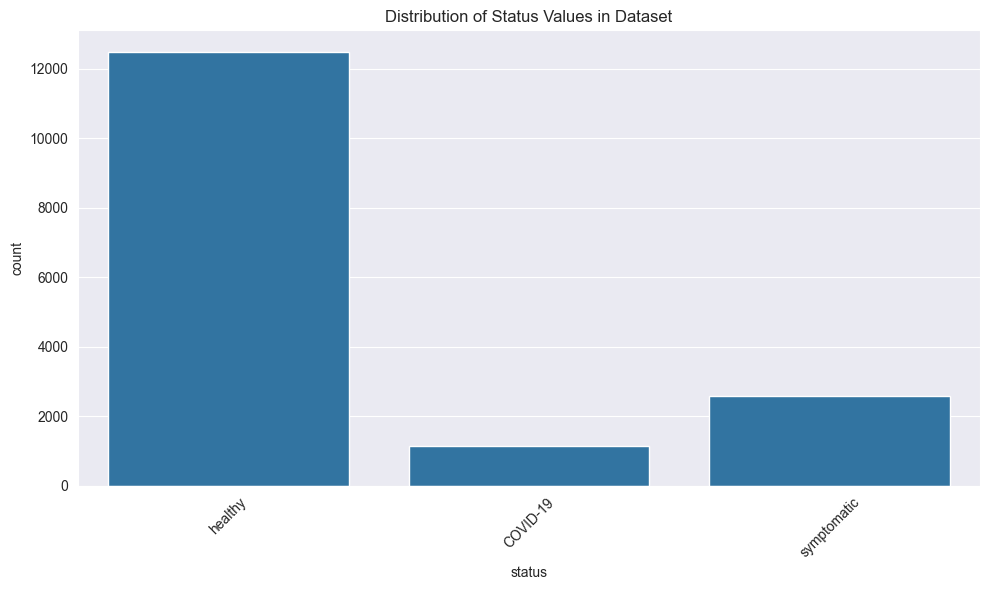

In [9]:

# Clean up rows with NA values in status column
print("Before cleaning: ", len(data_raw))
data_clean = data_raw.dropna(subset=['status'])
print("After removing NA status values: ", len(data_clean))

# Analyze status column types
status_counts = data_clean.status.value_counts()
print("\nStatus distribution:")
print(status_counts)

# Create a visualization of the status distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=data_clean, x='status')
plt.title('Distribution of Status Values in Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
# Get a subset of data for model training with balanced classes
def get_balanced_dataset(df, target_col='status', n_per_class=None):
    """
    Get a balanced dataset with equal representation of each class
    
    Args:
        df: DataFrame containing the data
        target_col: Column name for the target variable
        n_per_class: Number of samples per class (if None, uses the smallest class count)
        
    Returns:
        Balanced DataFrame
    """
    classes = df[target_col].unique()
    
    if n_per_class is None:
        # Get the count of the smallest class
        n_per_class = df[target_col].value_counts().min()
    
    balanced_data = []
    for cls in classes:
        # Get all samples of this class
        cls_data = df[df[target_col] == cls]
        
        # If we have more samples than needed, randomly sample
        if len(cls_data) > n_per_class:
            cls_data = cls_data.sample(n=n_per_class, random_state=42)
        
        balanced_data.append(cls_data)
    
    # Combine all balanced class data
    balanced_df = pd.concat(balanced_data).reset_index(drop=True)
    return balanced_df

# Create a balanced dataset with equal representation of each status
balanced_data = get_balanced_dataset(data_clean, target_col='status')
print(f"Balanced dataset size: {len(balanced_data)}")
print(balanced_data.status.value_counts())


Balanced dataset size: 3465
status
healthy        1155
COVID-19       1155
symptomatic    1155
Name: count, dtype: int64


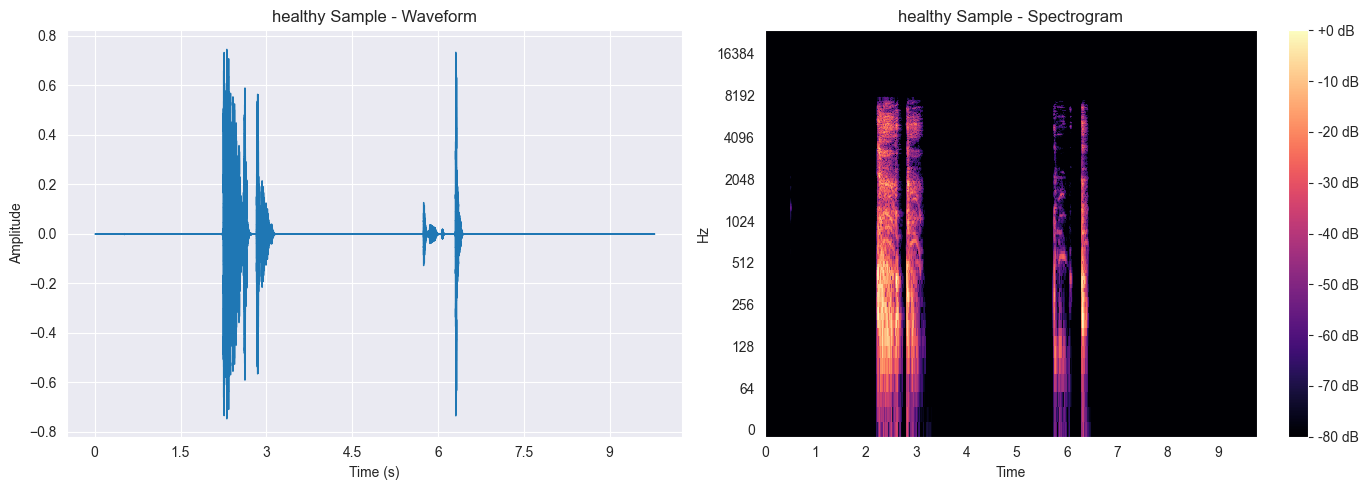

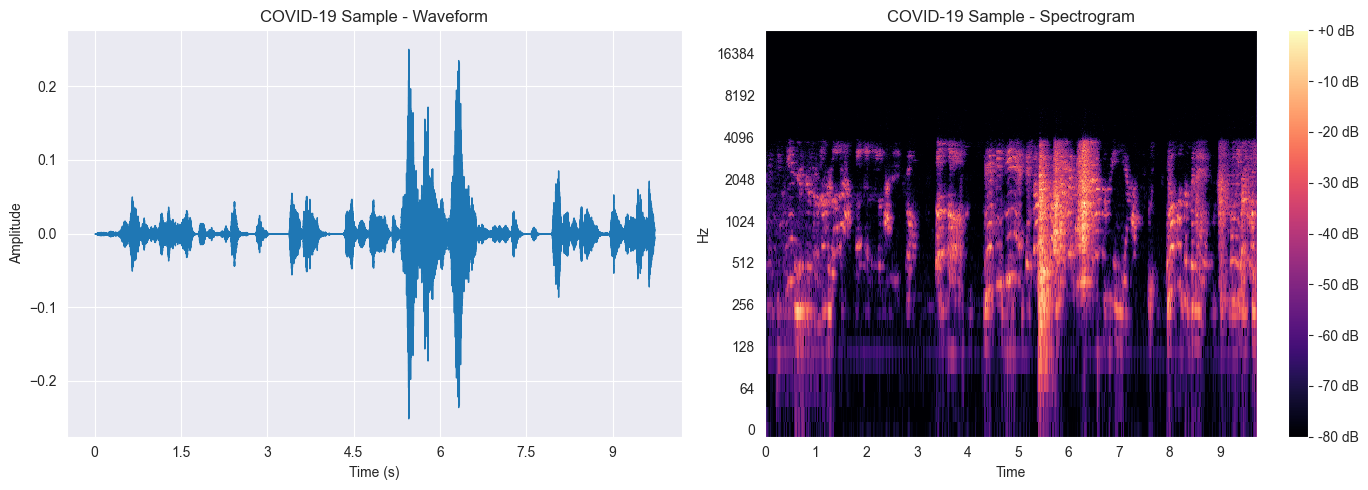

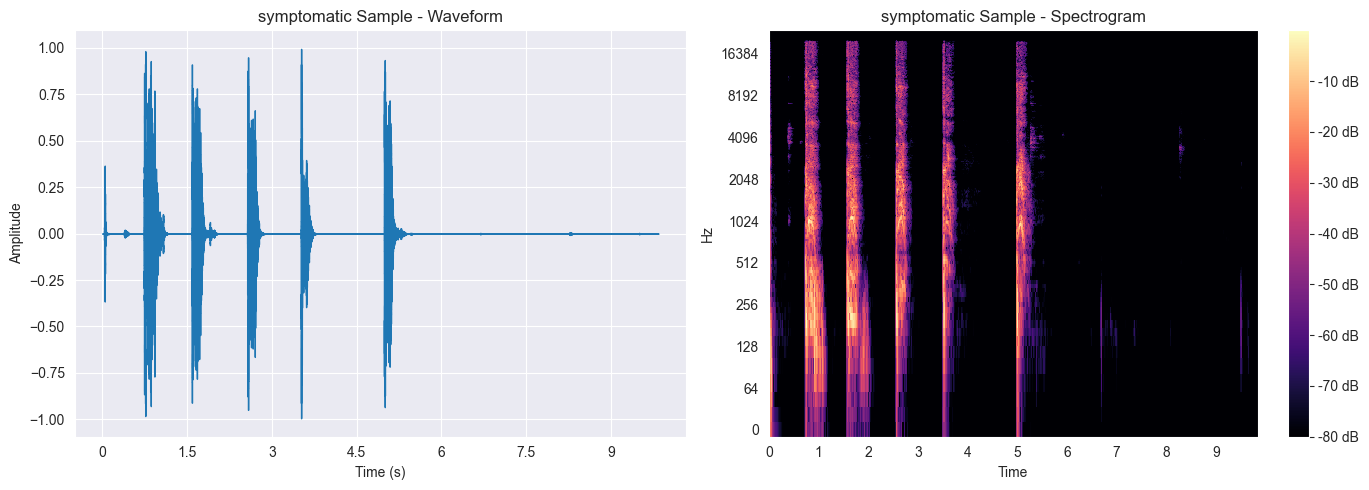

In [11]:
# Feature extraction from audio files


# Function to visualize audio waveform and spectrogram
def visualize_audio(audio, sample_rate, title="Audio Visualization"):
    plt.figure(figsize=(14, 5))
    
    # Plot waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(audio, sr=sample_rate)
    plt.title(f"{title} - Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    # Plot spectrogram
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"{title} - Spectrogram")
    
    plt.tight_layout()
    plt.show()

# Visualize samples from each class
for status in ['healthy', 'COVID-19', 'symptomatic']:
    # Get a sample file
    sample_file = data_clean[data_clean.status == status].iloc[0].uuid
    audio_path = os.path.join(ROOT, f"{sample_file}.wav")
    
    # Load audio
    audio, sample_rate = librosa.load(audio_path, sr=None)
    
    # Visualize
    visualize_audio(audio, sample_rate, title=f"{status} Sample")


In [12]:
# Extract features from balanced dataset
def extract_all_features(audio_path, sample_rate=None):
    """Extract comprehensive set of audio features"""
    # Load audio file
    y, sr = librosa.load(audio_path, sr=sample_rate)
    
    # Basic features
    features = {}
    
    # Duration
    features['duration'] = librosa.get_duration(y=y, sr=sr)
    
    # RMS Energy
    features['rms_mean'] = np.mean(librosa.feature.rms(y=y)[0])
    features['rms_std'] = np.std(librosa.feature.rms(y=y)[0])
    
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    features['zcr_mean'] = np.mean(zcr)
    features['zcr_std'] = np.std(zcr)
    
    # Spectral Features
    # Spectral Centroid
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(centroid)
    features['spectral_centroid_std'] = np.std(centroid)
    
    # Spectral Bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    features['spectral_bandwidth_mean'] = np.mean(bandwidth)
    features['spectral_bandwidth_std'] = np.std(bandwidth)
    
    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features['spectral_contrast_mean'] = np.mean(contrast)
    features['spectral_contrast_std'] = np.std(contrast)
    
    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    features['rolloff_mean'] = np.mean(rolloff)
    features['rolloff_std'] = np.std(rolloff)
    
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc{i+1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc{i+1}_std'] = np.std(mfccs[i])
    
    # Chroma Features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_mean'] = np.mean(chroma)
    features['chroma_std'] = np.std(chroma)
    
    return features

# Extract features for the balanced dataset
print("Extracting features from balanced dataset...")
features_list = []

# Process a subset for demonstration
sample_size = min(300, len(balanced_data))
subset_data = balanced_data.sample(sample_size, random_state=42)

for idx, row in tqdm(subset_data.iterrows(), total=len(subset_data)):
    try:
        audio_path = os.path.join(ROOT, f"{row.uuid}.wav")
        features = extract_all_features(audio_path)
        features['status'] = row.status
        features_list.append(features)
    except Exception as e:
        print(f"Error processing {row.uuid}: {e}")

# Create features dataframe
features_df = pd.DataFrame(features_list)
print(f"Extracted features for {len(features_df)} files")
features_df.head()


Extracting features from balanced dataset...


100%|██████████| 300/300 [01:28<00:00,  3.40it/s]

Extracted features for 300 files


,duration,rms_mean,rms_std,zcr_mean,zcr_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_contrast_mean,...,mfcc10_std,mfcc11_mean,mfcc11_std,mfcc12_mean,mfcc12_std,mfcc13_mean,mfcc13_std,chroma_mean,chroma_std,status
0,2.22,0.021312,0.033300,0.011639,0.018830,1223.989033,1952.095922,1718.855382,1917.885256,17.726323,...,7.259752,1.863421,7.665131,-5.721279,7.392523,-9.226194,11.405332,0.349352,0.348457,symptomatic
1,8.34,0.010328,0.033537,0.057935,0.025597,2737.021875,875.479747,3553.163721,1122.854903,14.743650,...,8.188354,-3.086511,8.094081,-3.638991,8.028049,-2.208702,7.505929,0.532127,0.285570,healthy
2,9.84,0.024282,0.050769,0.151033,0.059455,5000.663247,1970.071658,4016.133246,1963.421644,16.453290,...,11.409578,-16.673243,19.900339,3.351302,6.497612,10.605818,12.250504,0.451218,0.307002,symptomatic
3,9.84,0.012356,0.040303,0.076772,0.034019,5572.906516,2476.080194,5501.143466,2041.733851,14.158316,...,8.548441,-2.047793,9.692626,1.048577,7.078283,1.136109,6.871732,0.499278,0.306354,COVID-19
4,9.96,0.076443,0.135815,0.062263,0.039801,1973.557559,1147.678522,1832.054020,653.594992,17.551733,...,10.855228,-4.384065,11.292644,-7.926491,11.124605,-6.820267,13.002497,0.361000,0.324403,COVID-19


Training Random Forest model...

Classification Report:
              precision    recall  f1-score   support

    COVID-19       0.47      0.39      0.43        23
     healthy       0.56      0.56      0.56        25
 symptomatic       0.25      0.33      0.29        12

    accuracy                           0.45        60
   macro avg       0.43      0.43      0.42        60
weighted avg       0.46      0.45      0.45        60



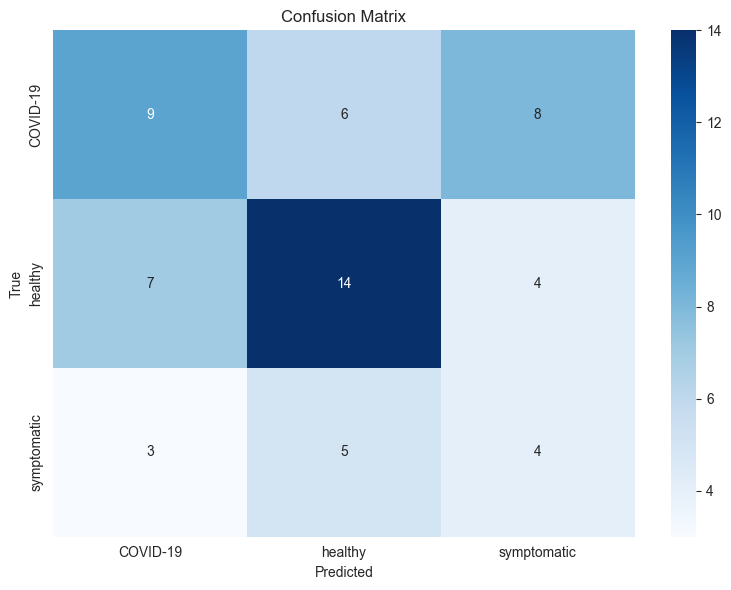

In [13]:
# Create a machine learning model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Prepare data for modeling
X = features_df.drop('status', axis=1)
y = features_df['status']

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a classifier
print("Training Random Forest model...")
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Evaluate
y_pred = clf.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


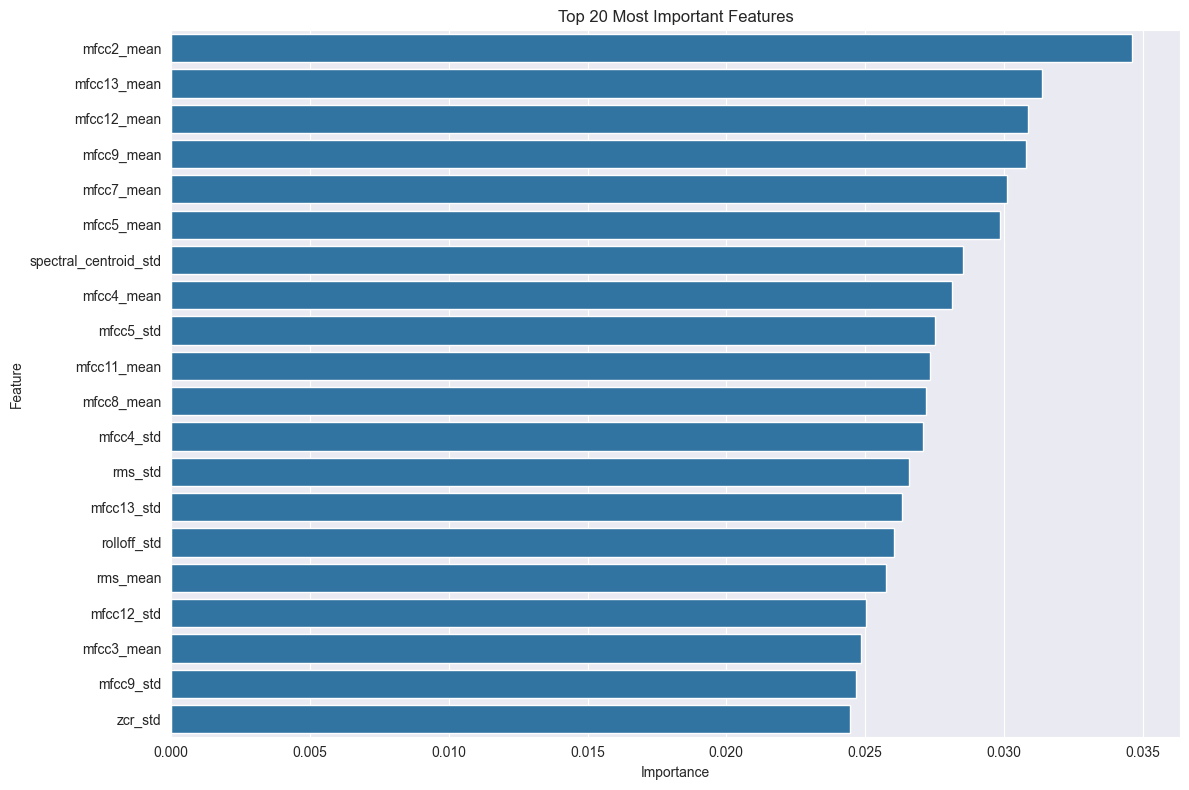

In [14]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()


In [15]:
# Save the model and preprocessing components
import pickle

model_components = {
    'model': clf,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'feature_names': X.columns.tolist()
}

with open('cough_classification_model.pkl', 'wb') as f:
    pickle.dump(model_components, f)

print("Model and preprocessing components saved to 'cough_classification_model.pkl'")


Model and preprocessing components saved to 'cough_classification_model.pkl'


In [16]:
# Test the saved model on a new sample
def predict_cough_health(audio_path, model_path='cough_classification_model.pkl'):
    # Load model components
    with open(model_path, 'rb') as f:
        components = pickle.load(f)
    
    model = components['model']
    scaler = components['scaler']
    label_encoder = components['label_encoder']
    feature_names = components['feature_names']
    
    # Extract features
    features = extract_all_features(audio_path)
    
    # Convert to DataFrame with correct feature order
    features_df = pd.DataFrame([features])
    features_df = features_df[feature_names]
    
    # Scale features
    features_scaled = scaler.transform(features_df)
    
    # Predict
    prediction_idx = model.predict(features_scaled)[0]
    prediction = label_encoder.inverse_transform([prediction_idx])[0]
    
    # Get probabilities
    probs = model.predict_proba(features_scaled)[0]
    class_probs = {label_encoder.inverse_transform([i])[0]: prob for i, prob in enumerate(probs)}
    
    return prediction, class_probs

# Test on a sample
test_file = data_clean.sample(1).iloc[0].uuid
test_path = os.path.join(ROOT, f"{test_file}.wav")
true_status = data_clean[data_clean.uuid == test_file].iloc[0].status

prediction, probabilities = predict_cough_health(test_path)

print(f"True status: {true_status}")
print(f"Predicted status: {prediction}")
print("Class probabilities:")
for cls, prob in probabilities.items():
    print(f"  {cls}: {prob:.4f}")



True status: healthy
Predicted status: healthy
Class probabilities:
  COVID-19: 0.2800
  healthy: 0.4000
  symptomatic: 0.3200


In [17]:
from huggingface_hub import notebook_login, HfApi
from huggingface_hub.utils import HfFolder
import os


In [18]:
notebook_login()

In [24]:
model_dir = "cough_classification_model"
os.makedirs(model_dir, exist_ok=True)

In [25]:
import shutil
shutil.copy("cough_classification_model.pkl", f"{model_dir}/cough_classification_model.pkl")


'cough_classification_model/cough_classification_model.pkl'

In [ ]:
with open(f"{model_dir}/README.md", "w") as f:
    f.write("""# Cough Classification Model

This model classifies cough sounds into different health statuses.

## Model Description
- **Model Type:** Random Forest Classifier
- **Features:** Audio features extracted from cough recordings
- **Classes:** COVID, healthy, symptomatic

## Usage

```python
import pickle

# Load model components
with open('cough_classification_model.pkl', 'rb') as f:
    components = pickle.load(f)

model = components['model']
scaler = components['scaler']
label_encoder = components['label_encoder']
feature_names = components['feature_names']
""")


In [27]:
api = HfApi()
repo_id = "greenarcade/cough-classification-model"

In [28]:
api.create_repo( repo_id=repo_id, private=False, exist_ok=True )

RepoUrl('https://huggingface.co/greenarcade/cough-classification-model', endpoint='https://huggingface.co', repo_type='model', repo_id='greenarcade/cough-classification-model')

In [29]:
api.upload_folder( folder_path=model_dir, repo_id=repo_id, repo_type="model" )

print(f"Model uploaded successfully to https://huggingface.co/{repo_id}")

cough_classification_model.pkl:   0%|          | 0.00/991k [00:00<?, ?B/s]

Model uploaded successfully to https://huggingface.co/greenarcade/cough-classification-model


In [30]:
def test_model_on_class(model_path, data_df, class_name, root_dir, n_samples=20):
    """
    Test the model on samples from a specific class

    Args:
        model_path: Path to the saved model pickle file
        data_df: DataFrame containing sample information
        class_name: Class to test (e.g., 'healthy', 'COVID-19', 'symptomatic')
        root_dir: Root directory of the audio files
        n_samples: Number of samples to test

    Returns:
        DataFrame with predictions and true labels
    """
    # Load model components
    with open(model_path, 'rb') as f:
        components = pickle.load(f)

    model = components['model']
    scaler = components['scaler']
    label_encoder = components['label_encoder']
    feature_names = components['feature_names']

    # Get samples from the specified class
    class_samples = data_df[data_df.status == class_name].sample(
        min(n_samples, len(data_df[data_df.status == class_name])),
        random_state=42
    )

    results = []

    for _, row in tqdm(class_samples.iterrows(), total=len(class_samples), desc=f"Testing {class_name}"):
        try:
            audio_path = os.path.join(root_dir, f"{row.uuid}.wav")

            # Extract features
            features = extract_all_features(audio_path)

            # Convert to DataFrame with correct feature order
            features_df = pd.DataFrame([features])
            features_df = features_df[feature_names]

            # Scale features
            features_scaled = scaler.transform(features_df)

            # Predict
            prediction_idx = model.predict(features_scaled)[0]
            prediction = label_encoder.inverse_transform([prediction_idx])[0]

            # Get probabilities
            probs = model.predict_proba(features_scaled)[0]

            result = {
                'uuid': row.uuid,
                'true_class': class_name,
                'predicted_class': prediction,
                'correct': prediction == class_name
            }

            # Add probabilities for each class
            for i, cls in enumerate(label_encoder.classes_):
                result[f'prob_{cls}'] = probs[i]

            results.append(result)

        except Exception as e:
            print(f"Error processing {row.uuid}: {e}")

    return pd.DataFrame(results)

In [31]:
def test_model(model_path, data_df, root_dir, n_samples_per_class=20):
    """Run tests on all three classes and aggregate results"""
    classes = ['healthy', 'COVID-19', 'symptomatic']
    all_results = []

    for cls in classes:
        class_results = test_model_on_class(model_path, data_df, cls, root_dir, n_samples_per_class)
        all_results.append(class_results)

    combined_results = pd.concat(all_results).reset_index(drop=True)
    return combined_results

In [32]:
def visualize_test_results(results_df):
    """Create visualizations of test results"""
    # Accuracy per class
    plt.figure(figsize=(10, 6))
    class_accuracy = results_df.groupby('true_class')['correct'].mean()
    sns.barplot(x=class_accuracy.index, y=class_accuracy.values)
    plt.title('Model Accuracy by Class')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    for i, acc in enumerate(class_accuracy):
        plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center')
    plt.show()

    # Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(
        results_df['true_class'],
        results_df['predicted_class'],
        labels=['healthy', 'COVID-19', 'symptomatic']
    )
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['healthy', 'COVID-19', 'symptomatic'],
               yticklabels=['healthy', 'COVID-19', 'symptomatic'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(
        results_df['true_class'],
        results_df['predicted_class'],
        target_names=['healthy', 'COVID-19', 'symptomatic']
    ))

    # Prediction probability distributions
    plt.figure(figsize=(15, 5))
    for i, cls in enumerate(['healthy', 'COVID-19', 'symptomatic']):
        plt.subplot(1, 3, i+1)
        data = results_df[results_df['true_class'] == cls]
        for target_cls in ['healthy', 'COVID-19', 'symptomatic']:
            sns.kdeplot(data[f'prob_{target_cls}'], label=target_cls)
        plt.title(f'True Class: {cls}')
        plt.xlabel('Prediction Probability')
        plt.ylabel('Density')
        plt.legend()
    plt.tight_layout()
    plt.show()

Testing symptomatic: 100%|██████████| 20/20 [00:04<00:00,  4.57it/s]


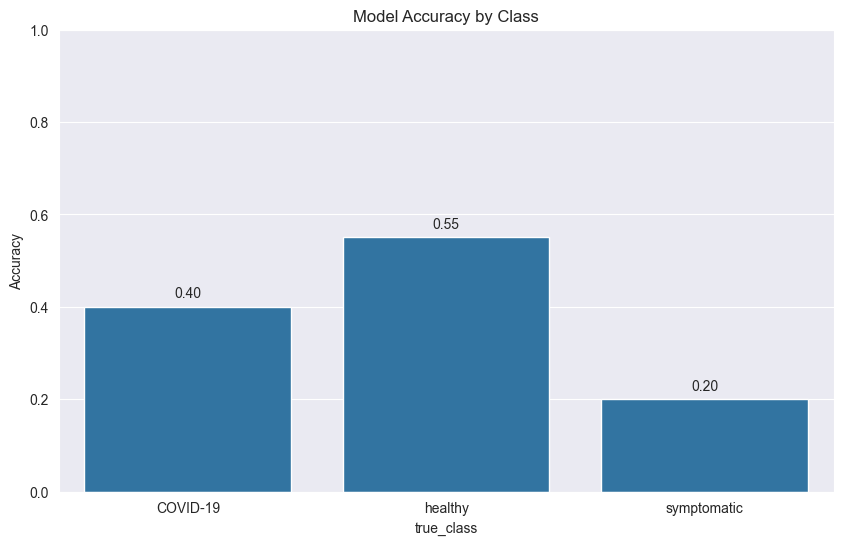

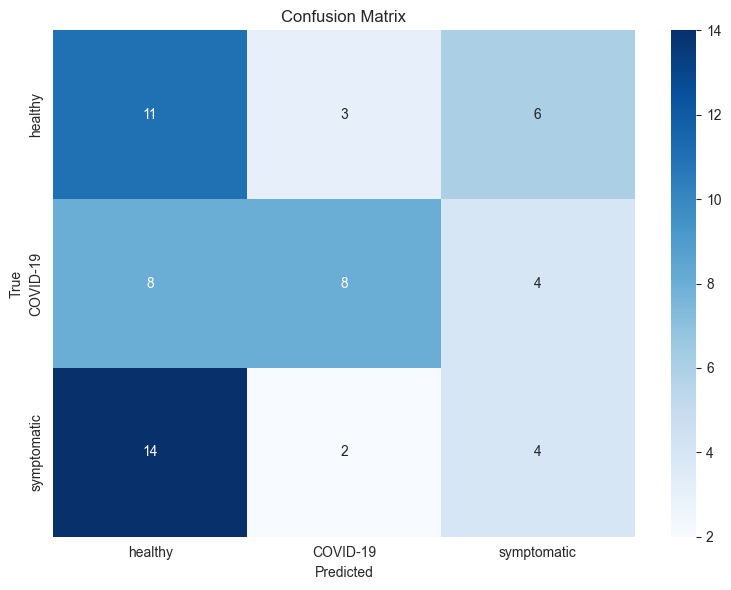


Classification Report:
              precision    recall  f1-score   support

     healthy       0.62      0.40      0.48        20
    COVID-19       0.33      0.55      0.42        20
 symptomatic       0.29      0.20      0.24        20

    accuracy                           0.38        60
   macro avg       0.41      0.38      0.38        60
weighted avg       0.41      0.38      0.38        60



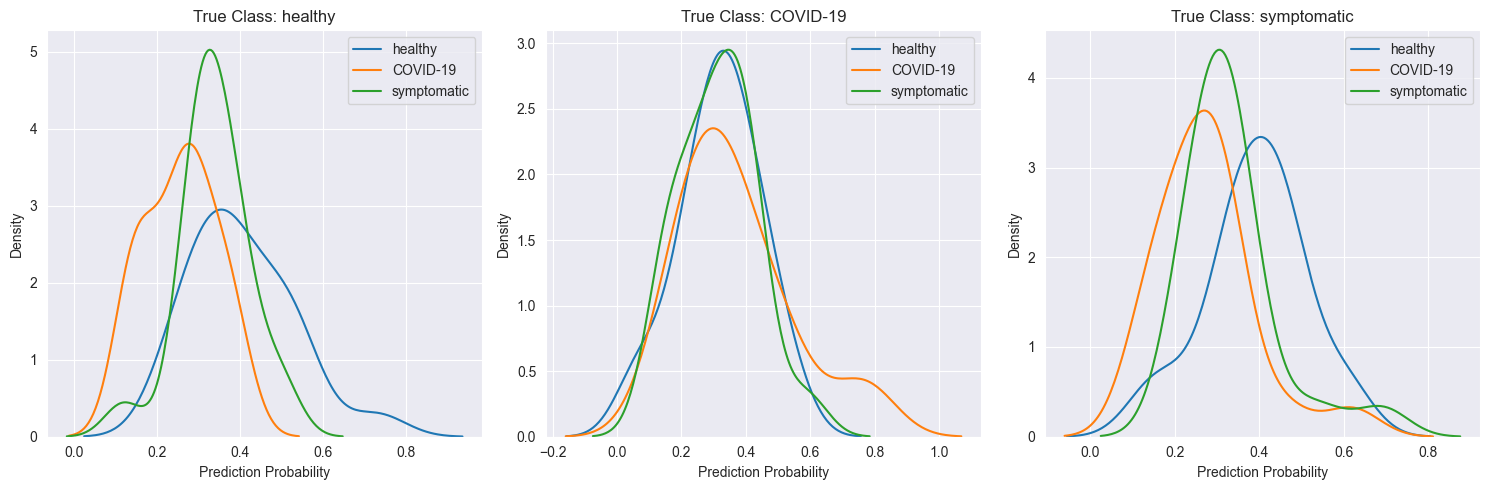

In [33]:
model_path = 'cough_classification_model.pkl'
test_results = test_model(model_path, data_clean, ROOT, n_samples_per_class=20)
visualize_test_results(test_results)

In [34]:
test_results.to_csv('model_test_results.csv', index=False)
print("Test results saved to 'model_test_results.csv'")


Test results saved to 'model_test_results.csv'


In [35]:
print("\nOverall Accuracy:", test_results['correct'].mean())
print("\nAccuracy by Class:")
print(test_results.groupby('true_class')['correct'].mean())



Overall Accuracy: 0.38333333333333336

Accuracy by Class:
true_class
COVID-19       0.40
healthy        0.55
symptomatic    0.20
Name: correct, dtype: float64


In [36]:
print("\nMisclassification Analysis:")
misclassified = test_results[~test_results['correct']]
if len(misclassified) > 0:
    print(misclassified.groupby(['true_class', 'predicted_class']).size().unstack(fill_value=0))
else:
    print("No misclassifications")


Misclassification Analysis:
predicted_class  COVID-19  healthy  symptomatic
true_class                                     
COVID-19                0        8            4
healthy                 3        0            6
symptomatic             2       14            0
